# Kaggle: Housing Prices 

In this notebook we explore the [housing prices kaggle challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) with Google Colab.  


For this challenge, I will use Keras+Tensorflow and other python libraries.

At the moment, I'm not sure how I can clone a github repository into Google Colab and open a notebook from that repostiroy (this notebook is copied into my Google Drive). 
So, this notebook will clone the [figment](https://github.com/demarley/figment) repository to access the kaggle dataset.


In [1]:
!git clone https://github.com/demarley/figment.git

Cloning into 'figment'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 14 (delta 1), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [2]:
# Now we can check that the repository has been cloned and has the data
!ls 

figment  sample_data


In [3]:
!ls figment/data

figment.png  housing_prices


## The Wilderness Must Be Explored!

With the dataset accessible, let's initially do some exploratory analysis to understand what data we have and what it looks like.  To do this I will use traditional python libraries, especially matplotlib, because those are the ones with which I am most familiar.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.style
import matplotlib as mpl
mpl.style.use("default")
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [0]:
df = pd.read_csv("drive/My Drive/ColabNotebooks/kaggle_housing_prices/train.csv"); # specific to my setup

### Quantifying Data

From the description file we know that some of these columns contain text rather than numerical data.  
I want to give numerical codes to these values (assuming at the moment that there is a finite number of options for these values) to use them directly in the training and visualize them with pandas.

In [0]:
str_data = {}
for i in df.columns:
    if isinstance(df[i][0],str):
        str_data[i] = list(set(df[i]))
        print(i,set(df[i])) # print the name of the column and unique values

MSZoning {'FV', 'C (all)', 'RH', 'RM', 'RL'}
Street {'Grvl', 'Pave'}
LotShape {'IR3', 'Reg', 'IR2', 'IR1'}
LandContour {'Lvl', 'HLS', 'Bnk', 'Low'}
Utilities {'AllPub', 'NoSeWa'}
LotConfig {'Inside', 'Corner', 'FR2', 'CulDSac', 'FR3'}
LandSlope {'Sev', 'Mod', 'Gtl'}
Neighborhood {'NWAmes', 'CollgCr', 'Veenker', 'Blueste', 'Somerst', 'ClearCr', 'SawyerW', 'Crawfor', 'Sawyer', 'Timber', 'NAmes', 'Blmngtn', 'MeadowV', 'Gilbert', 'BrkSide', 'StoneBr', 'IDOTRR', 'NPkVill', 'BrDale', 'SWISU', 'OldTown', 'Edwards', 'NoRidge', 'Mitchel', 'NridgHt'}
Condition1 {'RRNn', 'Norm', 'PosN', 'RRAe', 'Artery', 'Feedr', 'RRNe', 'RRAn', 'PosA'}
Condition2 {'RRNn', 'Norm', 'PosN', 'RRAe', 'Artery', 'Feedr', 'RRAn', 'PosA'}
BldgType {'TwnhsE', '2fmCon', 'Twnhs', '1Fam', 'Duplex'}
HouseStyle {'SFoyer', '2.5Unf', '2Story', 'SLvl', '1.5Fin', '1.5Unf', '2.5Fin', '1Story'}
RoofStyle {'Mansard', 'Flat', 'Hip', 'Shed', 'Gable', 'Gambrel'}
RoofMatl {'Membran', 'ClyTile', 'Metal', 'Tar&Grv', 'WdShake', 'CompShg', '

For each of these values, we will assign a number 0-N for the N unique values in the dataframe.
All of the `nan` values will receive a value of `-1`.

In [0]:
# First get all of the unique column names (except 'NaN')
values = []
cols   = list(str_data.keys())

for k in cols:
    for sd in str_data[k]:
        try:
            np.isnan(sd)
        except TypeError:
            if sd not in values: values.append(sd)

# Next, let's assign an integer to each name
allvalues = {}
for v,val in enumerate(values):
    allvalues[val] = v

Now that we have unique integer values for each text value, let's update the dictionary

In [0]:
df = df.fillna(-1)  # fill NaNs with '-1'

In [0]:
for k in cols:
    for val in str_data[k]:
        try:
            np.isnan(val)
        except TypeError:
            df.loc[df[k] == val, k] = allvalues[val]

In [0]:
# Check that some of these worked
data = df['BsmtQual'].values
h,b = np.histogram(data)
bin_centers = 0.5*(b[:-1]+b[1:])
print(bin_centers)

[  4.55  15.65  26.75  37.85  48.95  60.05  71.15  82.25  93.35 104.45]


(array([121., 618.,  35., 649.]),
 array([107.  , 107.75, 108.5 , 109.25, 110.  ]),
 <a list of 4 Patch objects>)

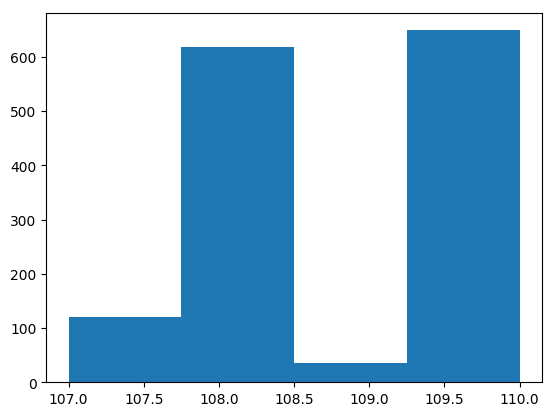

In [0]:
plt.hist(data[np.where(data>0)],bins=4)

### Making Plots

Visualizing the different distributions & looking at correlations help me to understand what kind of data I have.  
To that end, let's start making plots and trying to understand which features might be best for predicting the sale price.

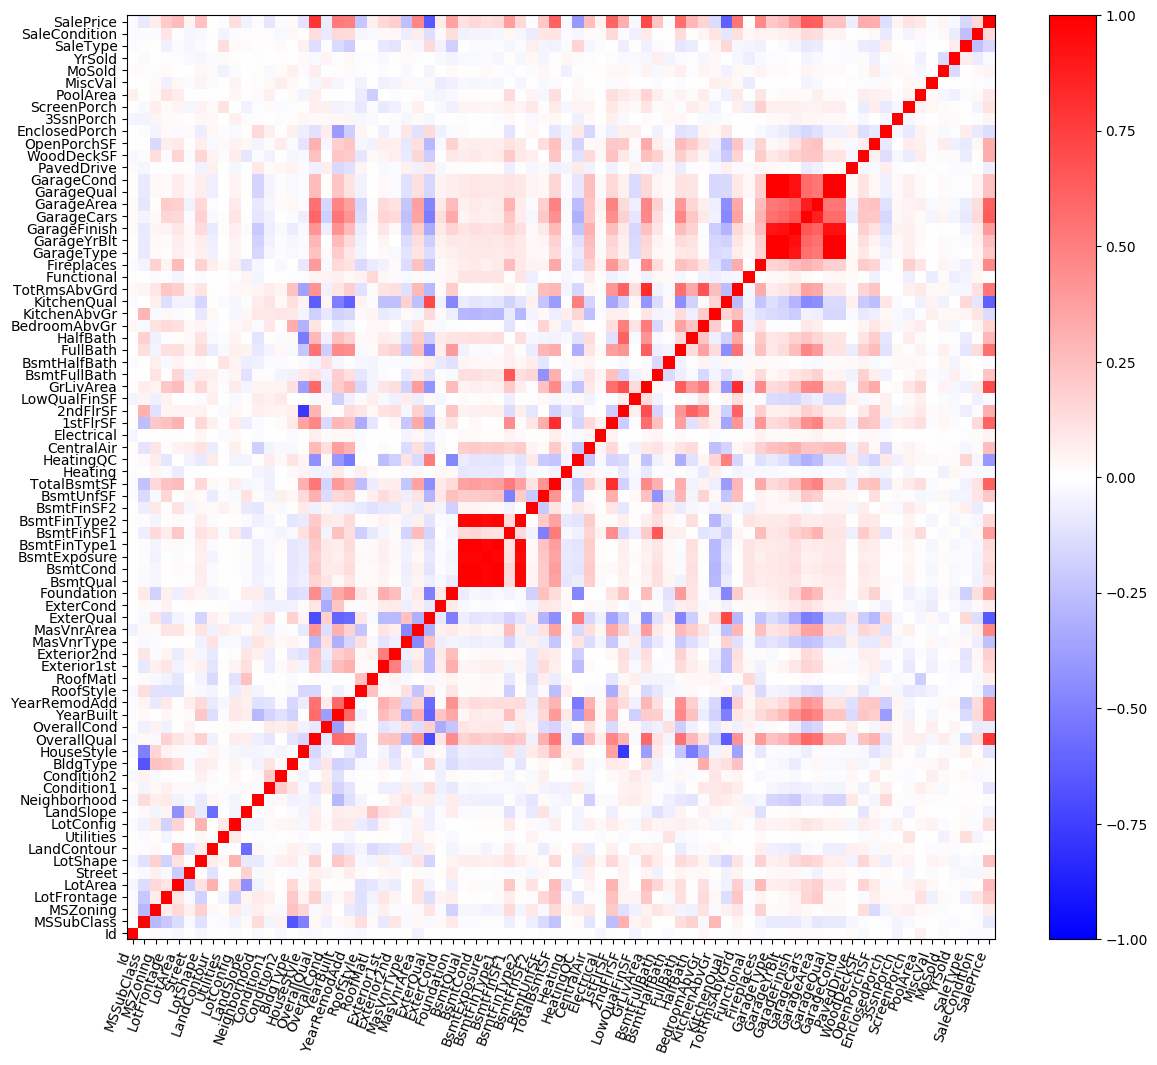

In [0]:
corrmat = df.corr()

fig,ax  = plt.subplots(figsize=(14,12))

opts    = {'cmap':plt.get_cmap("bwr"),'vmin':-1,'vmax':1}
heatmap = plt.pcolor(corrmat, **opts)
cbar    = plt.colorbar(heatmap, ax=ax)

labels = corrmat.columns.values

# shift location of ticks to center of the bins
ax.set_xticks(np.arange(len(labels))+0.5, minor=False);
ax.set_yticks(np.arange(len(labels))+0.5, minor=False);
ax.set_xticklabels(labels, fontsize=10, minor=False, ha='right', rotation=70);
ax.set_yticklabels(labels, fontsize=10, minor=False);

There are quite a few features, many of them don't seem to be strongly correlated (given the largely "white" matrix).  
As expected, many related variables are strongly correlated, e.g., the basement, garage, and bathroom features.  
Beyond that, let's start looking at some of these that are correlated with sale price to see if it's possible to only use a few features to get great performance.

In [0]:
vals = corrmat.SalePrice.values
med = np.median(vals)
rms = np.std(vals)
print("Distribution: {0} +/- {1}".format(med,rms))

Distribution: 0.12145727424996734 +/- 0.2876306072489093


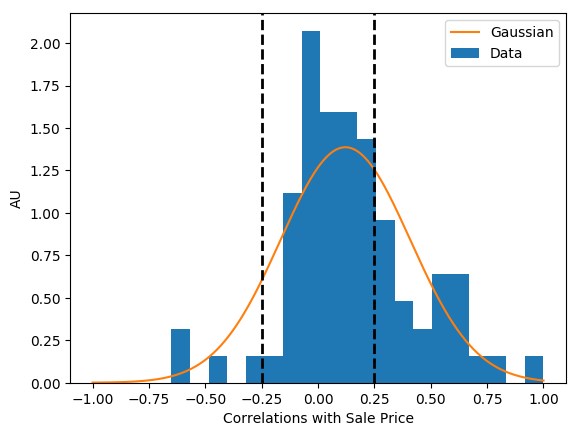

In [0]:
n = 1000
x = np.linspace(-1,1,n)
y = (1 / (np.sqrt(2 * np.pi * np.power(rms, 2)))) * \
    (np.power(np.e, -(np.power((x - med), 2) / (2 * np.power(rms, 2)))))

h,b,p = plt.hist(vals,bins=20,label="Data",normed=True);
plt.plot(x,integral*y,label="Gaussian")

plt.xlabel("Correlations with Sale Price")
plt.ylabel("AU")
plt.axvline(x=0.25,lw=2,ls='--',color='k')
plt.axvline(x=-0.25,lw=2,ls='--',color='k')
plt.legend()

So, it looks like most correlation values are close to 0.0. 
However, there are some larger correlations.  Let's look closer at those where `|rho|>0.25`

In [0]:
# Positive Correlations
corrmat[corrmat.SalePrice>0.25].SalePrice

LotArea         0.263843
OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472585
Foundation      0.363043
BsmtFinSF1      0.386420
TotalBsmtSF     0.613581
CentralAir      0.251328
1stFlrSF        0.605852
2ndFlrSF        0.319334
GrLivArea       0.708624
FullBath        0.560664
HalfBath        0.284108
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.261354
GarageFinish    0.391253
GarageCars      0.640409
GarageArea      0.623431
WoodDeckSF      0.324413
OpenPorchSF     0.315856
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [0]:
# Negative Correlations
corrmat[corrmat.SalePrice<-0.25].SalePrice

ExterQual     -0.650130
HeatingQC     -0.404483
KitchenQual   -0.619235
Name: SalePrice, dtype: float64

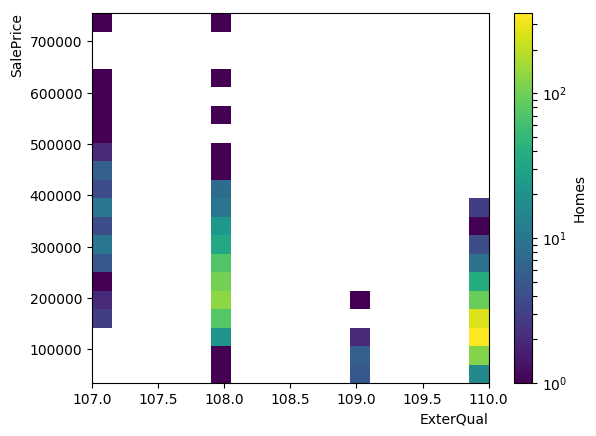

In [0]:
plt.hist2d(df.ExterQual,df.SalePrice,bins=20,cmap='viridis',norm=LogNorm());
plt.colorbar(label="Homes");
plt.ylabel("SalePrice",position=(0,1),ha='right');
plt.xlabel("ExterQual",position=(1,0),ha='right');

At first glance it seems odd that the exterior quality would be anti-correlated with sale price.
However, we can see that this was one of the columns that had textual data I converted into numerical data.  So, we can check exactly what's going on:

In [0]:
print(str_data['ExterQual'])
for i in str_data['ExterQual']:
    print(i,allvalues[i])

['Ex', 'Gd', 'Fa', 'TA']
Ex 107
Gd 108
Fa 109
TA 110


And everything seems reasonable now.  The "Excellent" category got a lower number the others because of how it was ordered in the list.  For now, I will leave this as it is, but this may be something we need to revisit and hand-label the textual data values to get 'proper' correlations.

Now let's just make a few other plots to understand the different correlations that revealed themselves above.

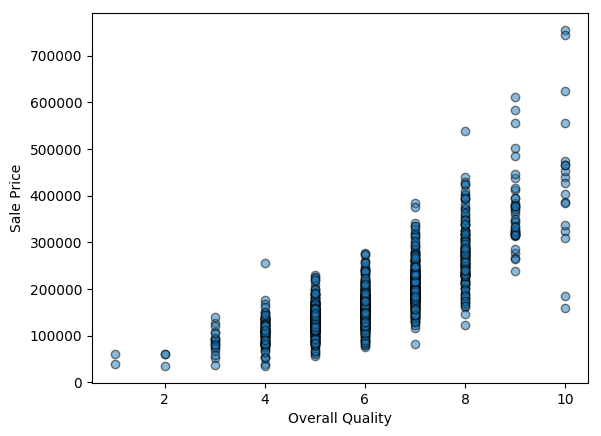

In [0]:
plt.scatter(df['OverallQual'],df['SalePrice'],edgecolor='k',alpha=0.5);
plt.ylabel("Sale Price");
plt.xlabel("Overall Quality");

The scatter plot is nice, but the points are so dense I would rather plot this as a 2d histogram.

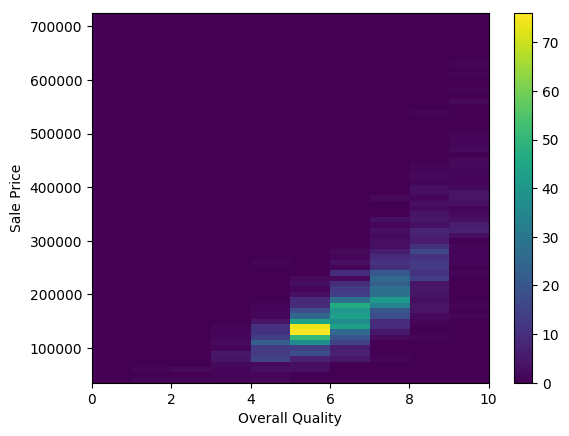

In [0]:
binning = [range(11),[34900+i*10000 for i in range(70)]]    # modify bins
plt.hist2d(df['OverallQual'],df['SalePrice'],bins=binning);
plt.ylabel("Sale Price");
plt.xlabel("Overall Quality");
plt.colorbar()

In [0]:
poscorrs = np.abs(corrmat[np.abs(corrmat.SalePrice)>0.6].SalePrice)
poscorrs.sort_values()

1stFlrSF       0.605852
TotalBsmtSF    0.613581
KitchenQual    0.619235
GarageArea     0.623431
GarageCars     0.640409
ExterQual      0.650130
GrLivArea      0.708624
OverallQual    0.790982
SalePrice      1.000000
Name: SalePrice, dtype: float64

For values with (absolute value) correlations above 0.6, there are only 8 features that meet this criteria, and none of them are correlated stronger than 0.8. 

Before going too far, let's check how correlated each of these are with each other!

In [0]:
params = poscorrs.keys()
tmp = corrmat[np.abs(corrmat.SalePrice)>0.6][params]

tmp

,OverallQual,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,KitchenQual,GarageCars,GarageArea,SalePrice
OverallQual,1.000000,-0.696937,0.537808,0.476224,0.593007,-0.638223,0.600671,0.562022,0.790982
ExterQual,-0.696937,1.000000,-0.440210,-0.363302,-0.420987,0.715401,-0.511437,-0.479510,-0.650130
TotalBsmtSF,0.537808,-0.440210,1.000000,0.819530,0.454868,-0.389273,0.434585,0.486665,0.613581
1stFlrSF,0.476224,-0.363302,0.819530,1.000000,0.566024,-0.347814,0.439317,0.489782,0.605852
GrLivArea,0.593007,-0.420987,0.454868,0.566024,1.000000,-0.406285,0.467247,0.468997,0.708624
KitchenQual,-0.638223,0.715401,-0.389273,-0.347814,-0.406285,1.000000,-0.463744,-0.440525,-0.619235
GarageCars,0.600671,-0.511437,0.434585,0.439317,0.467247,-0.463744,1.000000,0.882475,0.640409
GarageArea,0.562022,-0.479510,0.486665,0.489782,0.468997,-0.440525,0.882475,1.000000,0.623431
SalePrice,0.790982,-0.650130,0.613581,0.605852,0.708624,-0.619235,0.640409,0.623431,1.000000


In [0]:
np.min(np.abs(tmp.values))

0.3478136808329524

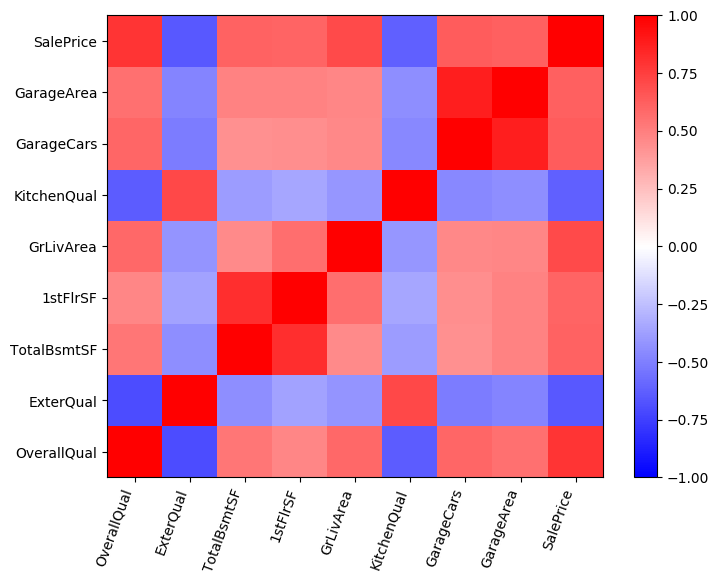

In [0]:
# plot the reduced correlation matrix
fig,ax  = plt.subplots(figsize=(8,6))

opts    = {'cmap':plt.get_cmap("bwr"),'vmin':-1,'vmax':1}
heatmap = plt.pcolor(tmp, **opts)
cbar    = plt.colorbar(heatmap, ax=ax)

labels = params

# shift location of ticks to center of the bins
ax.set_xticks(np.arange(len(labels))+0.5, minor=False);
ax.set_yticks(np.arange(len(labels))+0.5, minor=False);
ax.set_xticklabels(labels, fontsize=10, minor=False, ha='right', rotation=70);
ax.set_yticklabels(labels, fontsize=10, minor=False);

Unfortunately, it appears that all of these are also strongly correlated with each other!

The smallest correlation is only 0.35 between `KitchenQual` and `1stFlrSF`.  
To me, this means that we won't be able to get a lot of extra information (if any) from these extra variables as we could from just a few of them.


Now that I've looked through these values, I'm feeling a little more comfortable trying out some solutions.

## Solution Attempts

My first attempt at doing this will be incredibly simple and basic.
Because I know that the `OverallQual` feature is most strongly correlated with `SalePrice`, I'm going to just use that value in a couple different ways to predict the outcome.


### First Approach: Linear Regression

Given all of the data points in the training set, I will pick 75% at random, do a linear fit to the scatter plot data of `SalePrice` vs `OverallQual`, and use the remaining 25% of the data to test this prediction.

To do the regression, I will just use `scipy`.

In [0]:
# Import some new modules
from sklearn.model_selection import train_test_split
from scipy import stats

In [0]:
# First, let's slice the dataframe into 'training' and 'validation' sets
tmp = df.sample(frac=1)
tts = train_test_split(df['OverallQual'].values,\
                       df['SalePrice'].values, \
                       test_size=0.25)
X_train,X_test,Y_train,Y_test = tts

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


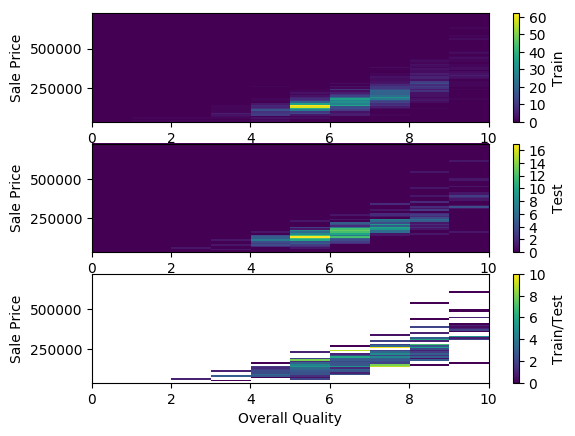

In [0]:
# let's check the differences between the test and train datasets
binning = [range(11),[34900+i*10000 for i in range(70)]]    # modify bins

fig,ax = plt.subplots(3,1)

plt.subplot(3, 1, 1)
train_h,train_bx,train_by = np.histogram2d(X_train,Y_train,bins=binning)
plt.hist2d(X_train,Y_train,bins=binning);
plt.ylabel("Sale Price");
plt.colorbar(label="Train")


plt.subplot(3, 1, 2)
test_h,test_bx,test_by = np.histogram2d(X_test,Y_test,bins=binning)
plt.hist2d(X_test,Y_test,bins=binning);
plt.ylabel("Sale Price");
plt.colorbar(label="Test")


plt.subplot(3, 1, 3)
# Take ratio, flatten and use as weights to make histogram (with dummy binning)
ratio   = np.divide(train_h,test_h).flatten()
center_x = 0.5*(test_bx[:-1]+test_bx[1:])
center_y = 0.5*(test_by[:-1]+test_by[1:])
dummy_x  = center_x.repeat(len(center_y))
dummy_y  = np.tile(center_y, (1,len(center_x)))[0]

plt.hist2d(dummy_x,dummy_y,bins=binning,weights=ratio);
plt.ylabel("Sale Price");
plt.xlabel("Overall Quality");
plt.colorbar(label="Train/Test")

plt.show()

Given the disparity in values (75% vs 25%) and fine binning, I don't see any cause for concern with how the dataset was split.

In [0]:
# Do the fit!
slope, intercept, r_value, p_value, std_err = stats.linregress(X_train,Y_train)
print(f"Slope     = {slope}")
print(f"Intercept = {intercept}")
print(f"R-vale    = {r_value}")
print(std_err)

Slope     = 45390.33678321385
Intercept = -95307.94065534501
R-vale    = 0.787917036038161
1072.999221289103


Now that we have the fit, let's make some plots and check how well it looks on the training and validation sets.

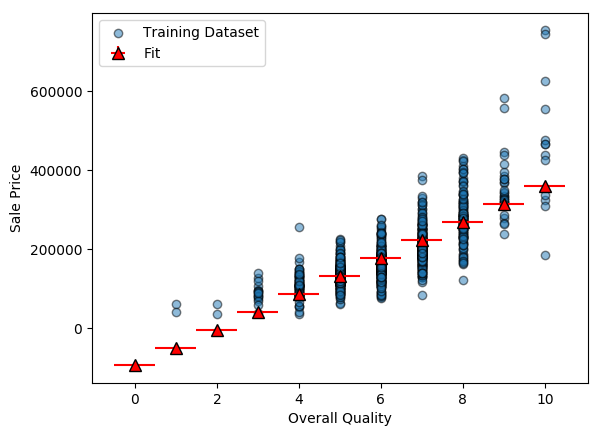

In [0]:
plt.scatter(X_train,Y_train,edgecolor='k',alpha=0.5,label="Training Dataset");
plt.errorbar(range(11),[slope*i+intercept for i in range(11)],\
             fmt='^',ms=9,mfc='r',mec='k',ecolor='r',\
             yerr=std_err,xerr=0.5,label='Fit')  # errorbar points at each 'OverallQual' value
plt.xlabel("Overall Quality");
plt.ylabel("Sale Price");
plt.legend()

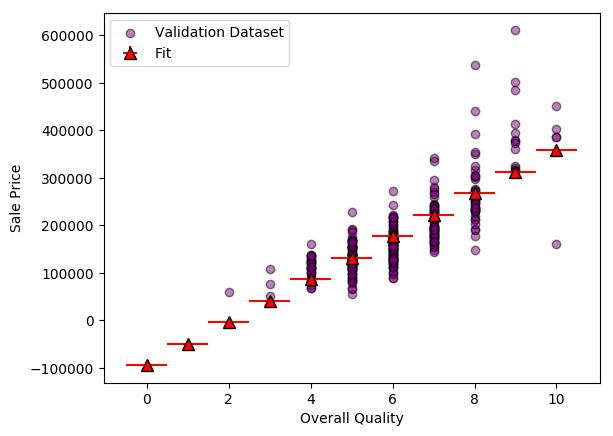

In [0]:
# And now plot with the 'validation' set
plt.scatter(X_test,Y_test,color='purple',edgecolor='k',alpha=0.5,label="Validation Dataset");
plt.errorbar(range(11),[slope*i+intercept for i in range(11)],\
             fmt='^',ms=9,mfc='r',mec='k',ecolor='r',\
             yerr=std_err,xerr=0.5,label='Fit')  # errorbar points at each 'OverallQual' value
plt.xlabel("Overall Quality");
plt.ylabel("Sale Price");
plt.legend()

And now plot the differences between the predicted sale price and the actual sale price to see how well it does!

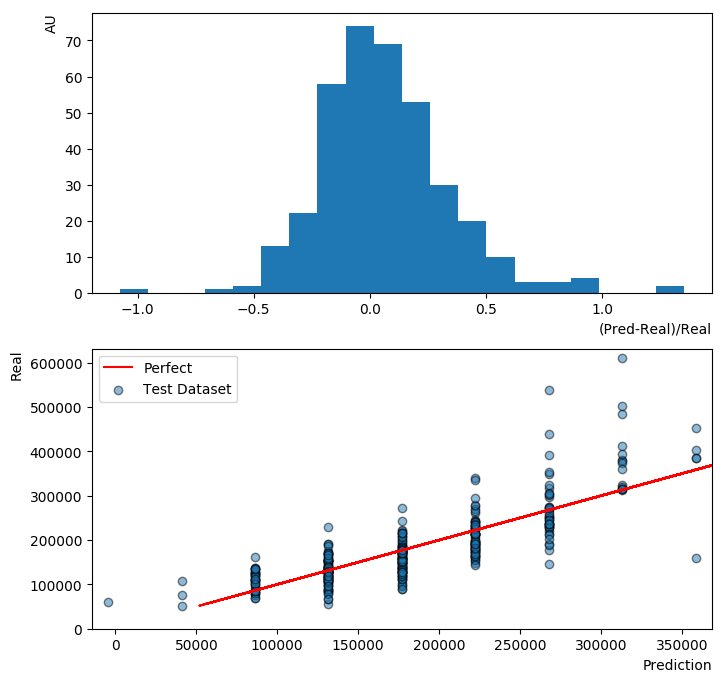

In [0]:
# Prediction: y=m*x+b
X_val = X_test.copy()
predictions = slope*X_val + intercept
values = np.divide((predictions - Y_test),Y_test)

fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test,edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test,Y_test,color='r',label="Perfect")
plt.xlim(min(predictions)-10000,max(predictions)+10000)
plt.ylim(0,max(Y_test)+20000)
plt.xlabel("Prediction",position=(1,0),ha='right')
plt.ylabel("Real",position=(0,1),ha='right')
plt.legend()

In [0]:
# Look at some stats on the relative difference:
print(" > Distribution = {0} +/- {1}".format(np.mean(values),np.std(values)))

 > Distribution = 0.06360771677407295 +/- 0.2808608879865465


For the linear fit, there are some striking issues:


1.   The prediction produces a negative value for low quality homes!
2.   The predicted values are grouped based on the `OverallQual` because only a single, identical value is predicted for the same input value.

A remedy to number 1 may be to try a different technique.


### Second Approach: Quadration Fit

Instead of a linear fit to the data as done above, I will now try a quadratic fit to see if there is any improvement in the results.

In [0]:
# Easy enough, numpy can do this:
deg2,deg1,intercept = np.polyfit(X_train,Y_train,2)

Now that we have the polynomial fit, we can plot the fit against the training and validation sets.

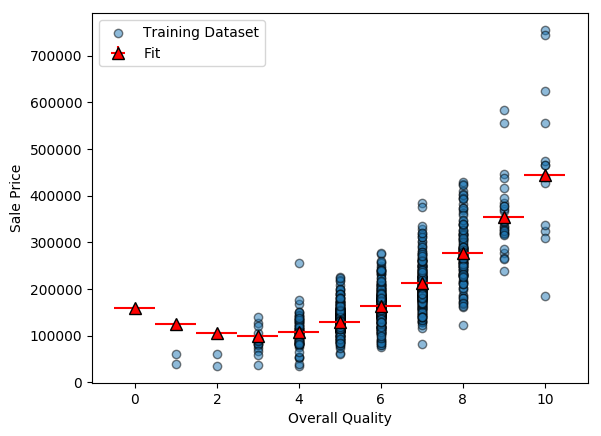

In [0]:
plt.scatter(X_train,Y_train,edgecolor='k',alpha=0.5,label="Training Dataset");
plt.errorbar(range(11),[deg2 * i**2 + deg1*i + intercept for i in range(11)],\
             fmt='^',ms=9,mfc='r',mec='k',ecolor='r',\
             yerr=std_err,xerr=0.5,label='Fit')  # errorbar points at each 'OverallQual' value
plt.xlabel("Overall Quality");
plt.ylabel("Sale Price");
plt.legend()

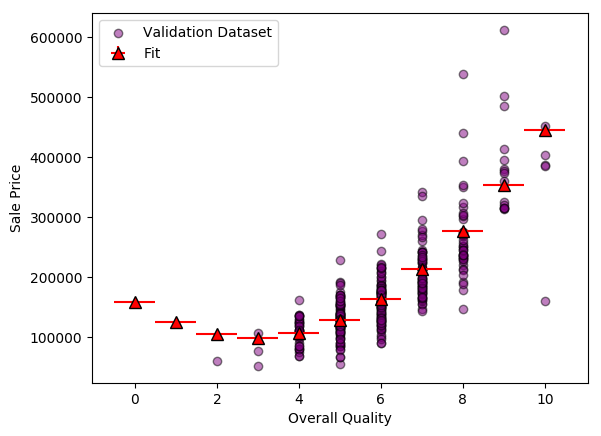

In [0]:
# And now plot with the 'validation' set
plt.scatter(X_test,Y_test,color='purple',edgecolor='k',alpha=0.5,label="Validation Dataset");
plt.errorbar(range(11),[deg2 * i**2 + deg1*i + intercept for i in range(11)],\
             fmt='^',ms=9,mfc='r',mec='k',ecolor='r',\
             yerr=std_err,xerr=0.5,label='Fit')  # errorbar points at each 'OverallQual' value
plt.xlabel("Overall Quality");
plt.ylabel("Sale Price");
plt.legend()

And now we can plot against the prediction to see if we did any better!

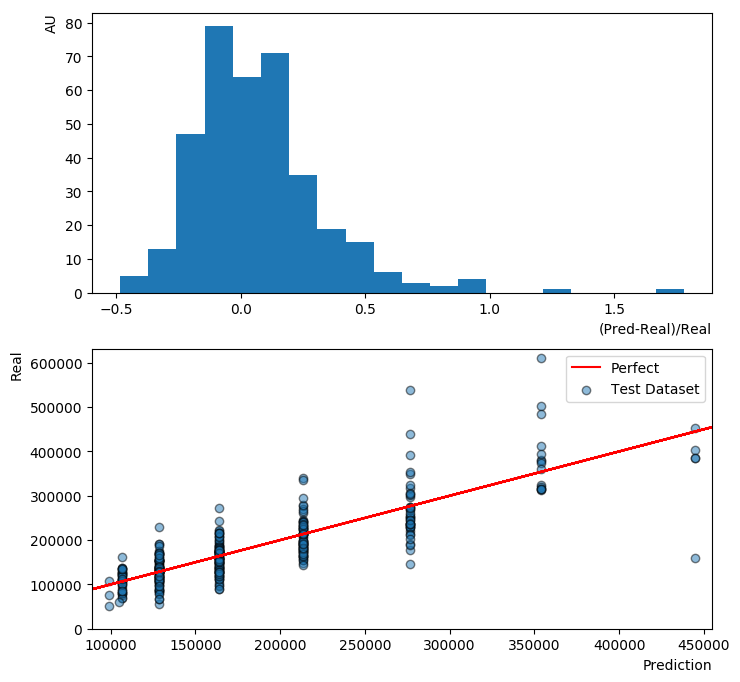

In [0]:
# Prediction: y=m*x+b
X_val = X_test.copy()
predictions = deg2 * np.square(X_val) + deg1*X_val + intercept
values = np.divide((predictions - Y_test),Y_test)

fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test,edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test,Y_test,color='r',label="Perfect")
plt.xlim(min(predictions)-10000,max(predictions)+10000)
plt.ylim(0,max(Y_test)+20000)
plt.xlabel("Prediction",position=(1,0),ha='right')
plt.ylabel("Real",position=(0,1),ha='right')
plt.legend()

In [0]:
# Look at some stats on the relative difference:
print(" > Distribution = {0} +/- {1}".format(np.mean(values),np.std(values)))

 > Distribution = 0.0682814649315412 +/- 0.2626747530523441


In compensating for the poor predictions at low quality values, we now overestimate the prices of the houses!  Additionally, the relative difference has roughly the same spread :(

#### Post-mortem 

There are obvious issues with these approaches.  
Namely, the prediction will always be the same for a particular value for `OverallQual`, no matter what the other features are (which leads to the odd distribution in the scatter plots above).

### Third Approach: Gaussian Variability
Another simple technique can circumvent this issue.  
In this instance, we will still use only `OverallQual` to predict the outcome, but we will allow for some variability.

For each value of `OverallQual`, let's determine the mean and RMS (from the training set).  
Then, when we are given a new `OverallQual` value, we sample from a Gaussian with the pre-determined values for mean and RMS. 

### Fourth Approach: Machine Learning

In the next notebook, we will explore more sophisticated multivariate techniques for doing the regression.